### Imports

In [173]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
import cvxpy
from matplotlib import pylab as plt
import sklearn.metrics
%matplotlib inline
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.cross_validation import train_test_split
from sklearn.kernel_ridge import KernelRidge

## Problem Set 4. Machine Learning. December 2015

### Makarova Anastasia

#### Problem 1

* Rewrite problem (2) in the vector form, i.e. get rid of the sum and rewrite the constraints in the form Au ⪯ v,
where A is some matrix, and u and v are some vectors

Letś introduce a vector $e = (1, \dots, 1)^T \in R^n$ 

\begin{equation*}
\begin{aligned}
& \underset{\omega, \xi}{\text{minimize}}
& & \frac{1}{n} \xi e + \frac{1}{2C} \omega^T \omega \\
& s.t.
& & \phi(x) \omega^T - y \leq \xi + \varepsilon e \\
& & & \phi(x) \omega^T - y \geq - \xi - \varepsilon e \\
& & &\xi \geq 0
\end{aligned}
\end{equation*}


#### Problem 2

Derive the dual problem to (2). You should get problem (3). What is the dimensionality of this problem?

* Let´s write Lagrangian

$$\mathscr{L}(\xi, \omega, \lambda, \mu, \nu) = \frac{1}{n} \xi e + \frac{1}{2C} \omega^T \omega + \lambda^T(\phi(x) \omega^T - y - \xi - \varepsilon e) + \mu^T(y - \xi - \varepsilon e - \phi(x) \omega^T) - \nu^T \xi $$

$$\lambda, \mu, \nu \geq 0$$


* Then, the goal of dual problem is to maximize the Lagrangian minimum		

$$g(\lambda, \mu, \nu) = \underset{\xi, \omega}{\text{min}}\  \mathscr{L}(\xi, \omega, \lambda, \mu, \nu)$$
	
$$\frac{\partial \mathscr{L}}{\partial \xi} = \frac{1}{n} e - \lambda - \mu - \nu  = 0  \ \ \ (1)$$
$$\frac{\partial \mathscr{L}}{\partial \omega} = \frac{1}{C} \omega + \phi(x)(\lambda - \mu) = 0 \ \ \ (2)$$

* Dual problem

\begin{equation*}
\begin{aligned}
& \underset{\lambda, \mu, \nu}{\text{maximize}}
& & g(\lambda, \mu, \nu) \\
& s.t.
& & \lambda, \mu, \nu \geq 0 \\
& & & \frac{d\mathscr{L}}{\partial \xi} = 0 
\end{aligned}
\end{equation*}

* From the $(2)$ equation: $\omega =  C \phi(x)(\mu - \lambda)$. Then, using also the $(1)$ and $g$

\begin{equation*}
\begin{aligned}
& \underset{\lambda, \mu, \nu}{\text{maximize}}
& & \frac{1}{2} C (\phi(x)(\mu - \lambda))^T\phi(x)(\mu - \lambda) + (\lambda^T - \mu^T)\phi(x)C (\phi(x)(\mu - \lambda))^T - \lambda^T(y + \varepsilon e) + \mu^T(y - \varepsilon e) \\
& s.t.
& & \lambda, \mu, \nu \geq 0 \\
& & & \frac{1}{n} e - \lambda - \mu - \nu = 0 
\end{aligned}
\end{equation*}

 

* Introducing a kernel $K(x, x) = \phi(x)^T \phi(x)$ we can rewrite dual problem with dimansionality 2n as: 

\begin{equation*}
\begin{aligned}
& \underset{\lambda, \mu, \nu}{\text{maximize}}
& & -\frac{1}{2} (\mu - \alpha) K(x, x) (\mu - \alpha) + y^T (\mu - \lambda) - \varepsilon e^T(\mu + \lambda) \\
& s.t.
& & \lambda, \mu, \nu \geq 0 \\
& & & \frac{1}{n} e - \lambda - \mu - \nu = 0 
\end{aligned}
\end{equation*}

#### Problem 3
Suppose you have an optimal solution $(λ^∗ , μ^∗ )$ of (3). Derive the formula for the prediction $\hat{y}(x_{new} )$ which
will not require to compute the feature transformation φ explicitly (i.e. it will contain only the corresponding
kernel).

* Prediction

$$\hat{y}(x_{new}) = C(\phi(x)(\mu - \lambda))^T\phi(x_{new}) = C (\mu^T - \lambda^T)\phi(x)^T \phi(x_{new}) = C (\mu^T - \lambda^T) K(x, x_{new})$$


#### Problem 4

Show how problem (3) can be rewritten as a convex QP in the standard form:

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \frac{1}{2} x^T P x + q^T x \\
& s.t.
& & Gx \leq h
\end{aligned}
\end{equation*}
Write the formulas which show what x, P , q, G and h are in the case of problem (3). Why will the matrix P
be positive semi-definite? 

* Because according to the definition of kernel function it should positive semidefinite and K is a blok matrix of K
	
* Then the components of the problem will be the next:
	
    
\begin{equation*}
\begin{aligned}
& x = \left( \begin{matrix} \lambda_{1}\\
				\vdots\\
				\lambda_n\\
				\mu_1\\
				\vdots\\
				\mu_n
			  \end{matrix} \right)
& & &P = \left( \begin{matrix}
				K & -K \\
				-K & K
       	      \end{matrix} \right) 
& & & q = \left( \begin{matrix}
			 y_1  + \varepsilon\\
			 \vdots\\
			 y_n + \varepsilon\\
			 -y_1  + \varepsilon\\
			 \vdots\\
			 -y_n + \varepsilon\\
	          \end{matrix} \right) \\
& & G = \left( \begin{matrix}
				 -I(n) & 0 \\
				 0 & -I(n)\\
				 I(n) & I(n)\\
	            \end{matrix} \right)
& & &h = \left( \begin{matrix}
			 	zeros((2n, 1))\\
			 	\frac{C}{n} ones((n, 1))
	     	 	\end{matrix} \right)
\end{aligned}
\end{equation*}    


#### Problem 5

Implement SVR using the formulas you derived. Your implementation must support three types of kernels:
linear, polynomial and RBF

In [171]:
class MySVR(BaseEstimator, RegressorMixin):
    def __init__(self, kernel='rbf', C=1.0, epsilon=0.1, gamma=1.0, p=1):
        self.kernel = kernel
        self.p = p
        self.C = C
        self.epsilon = epsilon
        self.gamma = gamma
        
    def fit(self, X, y):

        self.X = X

        kernels = {
            'linear': linear_kernel,
            'polynomial': lambda X, Y = None: polynomial_kernel(X, Y, degree=self.p, gamma=self.gamma),
            'rbf': lambda X, Y=None: rbf_kernel(X, Y, gamma=self.gamma) }

        self.kernel_function = kernels[self.kernel]
        K = self.kernel_function(X) 
        K = K - np.eye(K.shape[0])*np.linalg.eigvals(K).real.min()
        
        lamda = cvxpy.Variable(y.size)
        mu = cvxpy.Variable(y.size)
        
        constraints = [lamda >= 0, mu >= 0, lamda + mu <= self.C / y.size]
        
        f = - cvxpy.quad_form(mu - lamda, K)/2 + y.reshape(1, -1) * (mu - lamda) - self.epsilon * cvxpy.sum_entries(mu + lamda)
        objective = cvxpy.Maximize(f)


        prob = cvxpy.Problem(objective, constraints)
        prob.solve()
        
        
        self.lamda = lamda.value
        self.mu = mu.value
        return self

    def predict(self, X_new):
        y_new = self.kernel_function(X_new, self.X).dot(self.mu - self.lamda)
        return y_new

Score is 35.6883404344


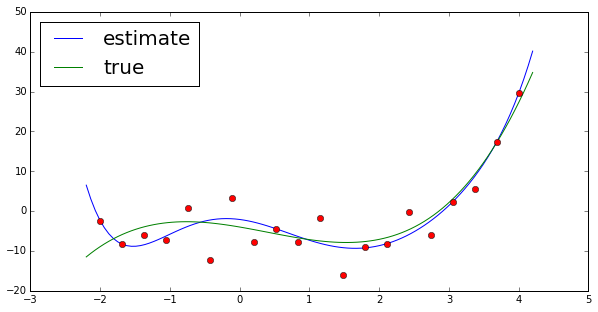

In [129]:
def f(x):
    return x ** 3 - (x + 2) ** 2 + np.sin(x)

np.random.seed(1)

X = np.linspace(-2, 4, 20).reshape(-1, 1)

y = f(X) + np.random.randn(*X.shape) * 4

X_test = np.linspace(-2.2, 4.2, 100).reshape(-1, 1)
y_true = f(X_test)

predictor = MySVR(kernel='rbf', C=100)
predictor.fit(X, y)
y_estimate = predictor.predict(X_test)

print('Score is {0}'.format(sklearn.metrics.mean_squared_error(y_estimate, y_true)))

plt.figure(figsize=(10, 5))
plt.plot(X_test, y_predicted, label='estimate')
plt.plot(X_test, y_true, label='true')
plt.plot(X, y, 'o')
plt.legend(loc='best', fontsize=20)
plt.show()

Score is 10.2232576355


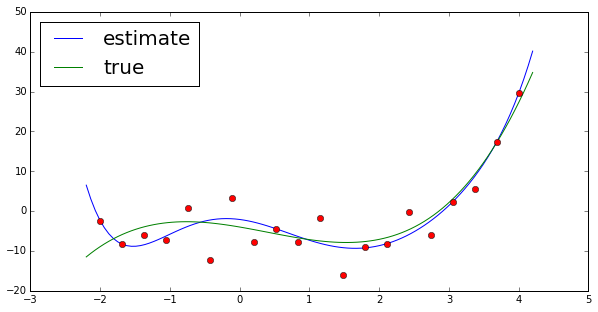

In [130]:
def f(x):
    return x ** 3 - (x + 2) ** 2 + np.sin(x)

np.random.seed(1)

X = np.linspace(-2, 4, 20).reshape(-1, 1)

y = f(X) + np.random.randn(*X.shape) * 4

X_test = np.linspace(-2.2, 4.2, 100).reshape(-1, 1)
y_true = f(X_test)

predictor = MySVR(kernel='polynomial', p=3, C=60, epsilon=1.0,)
predictor.fit(X, y)
y_estimate = svr.predict(X_test)
err = sklearn.metrics.mean_squared_error(y_estimate, y_true)
print('Score is {0}'.format(err))

plt.figure(figsize=(10, 5))
plt.plot(X_test, y_predicted, label='estimate')
plt.plot(X_test, y_true, label='true')
plt.plot(X, y, 'o')
plt.legend(loc='best', fontsize=20)
plt.show()

### Problem 7

Try to vary the regularization parameter C. What changes? What about ε

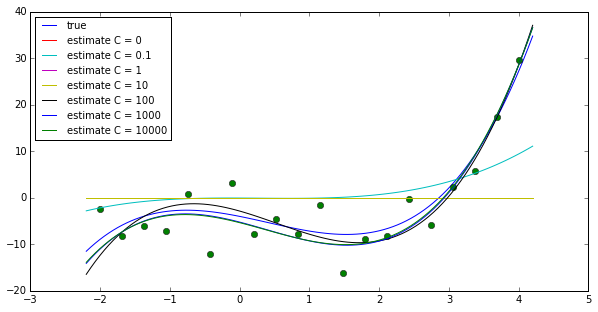

In [131]:
C = [0, 0.1, 1, 10, 100, 1000, 10000]

plt.figure(figsize=(10, 5))
plt.plot(X_test, y_actual, label='true')
plt.plot(X, y, 'o')

for c in C:
    predictor = MySVR(kernel='polynomial', p=3, C=c, epsilon=1.)
    predictor.fit(X, y)
    y_estimate = predictor.predict(X_test)
    plt.plot(X_test, y_estimate, label='estimate C = {0}'.format(c))

plt.legend(loc='best', fontsize=10)
plt.show()

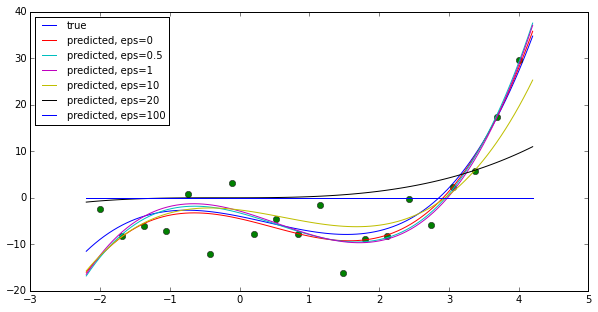

In [134]:
Epsilons = [0, 0.5, 1, 10, 20, 100]

plt.figure(figsize=(10, 5))
plt.plot(X_test, y_true, label='true')
plt.plot(X, y, 'o')

for epsilon in Epsilons:
    predictor = mySVR(kernel='polynomial', p=3, C=100, epsilon=epsilon)
    predictor.fit(X, y)
    y_estimate = predictor.predict(X_test)
    plt.plot(X_test, y_estimate, label='predicted, eps={0}'.format(epsilon))

plt.legend(loc='best', fontsize=10)
plt.show()

#### Problem 8
Find the best values of parameters C and ε using cross-validation. Has the prediction improved?

In [133]:
parameters = {
    'C': [0, 0.1, 1, 10, 100, 1000, 10000],
    'epsilon': [0, 0.01, 0.002, 0.5, 1, 10, 20, 100] }

gs = GridSearchCV(MySVR(kernel='polynomial', p=3), parameters, cv=10, scoring='mean_squared_error')
gs.fit(X, y)
print gs.best_params_

predictor = MySVR(kernel='polynomial', p = 3, **gs.best_params_)
predictor.fit(X, y)
y_estimate = predictor.predict(X_test)
score = sklearn.metrics.mean_squared_error(y_estimate, y_true)
print('The best score is {0}'.format(score))

{'epsilon': 0, 'C': 10000}
The best score is 1.98024019261


#### Problem 9

Investigate how the choice of a kernel affects the prediction (visually). What is the influence of the degree p
of the polynomial kernel and the bandwidth γ of the RBF kernel?

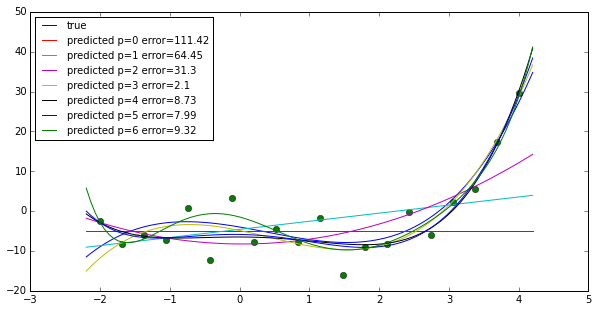

In [114]:
ps = np.arange(0, 7)

plt.figure(figsize=(10, 5))
plt.plot(X_test, y_true, label='true')
plt.plot(X, y, 'o')

for p in ps:
    predictor = MySVR(kernel='polynomial', p=p, **gs.best_params_)
    y_estimate = predictor.fit(X, y).predict(X_test)
    err = round(sklearn.metrics.mean_squared_error(y_estimate, y_true),2)
    plt.plot(X_test, y_estimate, label='predicted p={0} error={1}'.format(p, err))

plt.legend(loc='best', fontsize=10)
plt.show()

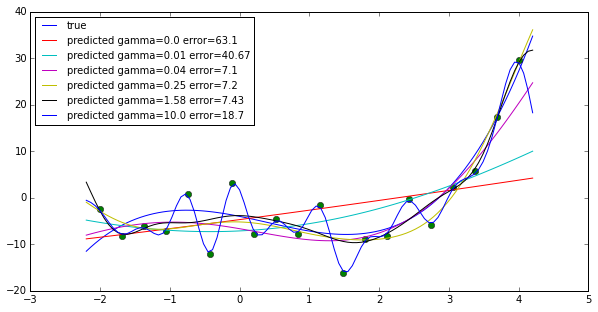

In [117]:
gammas = np.logspace(-3, 1, 6)

plt.figure(figsize=(10, 5))
plt.plot(X_test, y_true, label='true')
plt.plot(X, y, 'o')

for gamma in gammas:
    predictor = MySVR(kernel='rbf', gamma=gamma, **gs.best_params_)
    y_estimate = predictor.fit(X, y).predict(X_test)
    err = round(sklearn.metrics.mean_squared_error(y_estimate, y_true),2)
    plt.plot(X_test, y_estimate, label='predicted gamma={0} error={1}'.format(round(gamma,2), err))

plt.legend(loc='best', fontsize=10)
plt.show()

### Problem 10
For a given kernel (say, RBF), investigate how the accuracy and training time change in dependency of the
number n of training examples. Do the same for the SVR class from sklearn. How do its results differ from
your results?

In [196]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

N = [10, 50, 100, 200, 500]

my_time = []
my_scores = []
svr_time = []
svr_scores = []

for n in N:
    x = np.linspace(-5, 5, n).reshape(-1, 1)
    y = (np.exp(x).T + np.random.normal(0, 1, x.shape[0])).T
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

    svr1 = MySVR(kernel = 'rbf', gamma = 0.01, C = 100)
    time1 = %timeit -o svr1.fit(X_train, y_train)
    my_time.append(time1.best)
    my_scores.append(mean_squared_error(svr1.predict(X_test), y_test))
    
    svr2 = SVR(kernel = 'rbf', gamma = 0.01, C = 100)
    time2 = %timeit -o svr2.fit(X_train, y_train.ravel())
    svr_time.append(time2.best)
    svr_scores.append(mean_squared_error(svr2.predict(X_test), y_test))

10 loops, best of 3: 20.1 ms per loop
1000 loops, best of 3: 243 µs per loop
10 loops, best of 3: 43.7 ms per loop
1000 loops, best of 3: 669 µs per loop
10 loops, best of 3: 49.6 ms per loop
100 loops, best of 3: 1.69 ms per loop
10 loops, best of 3: 168 ms per loop
100 loops, best of 3: 6.45 ms per loop
1 loops, best of 3: 871 ms per loop
10 loops, best of 3: 39.1 ms per loop


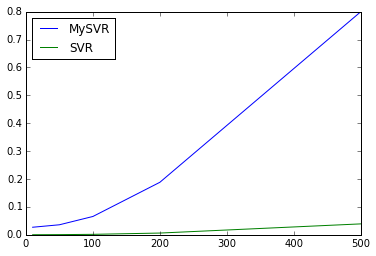

In [194]:
plt.plot(N, my_time, label = 'MySVR')
plt.plot(N, svr_time, label = 'SVR')
plt.legend(loc = 'best')

plt.show()

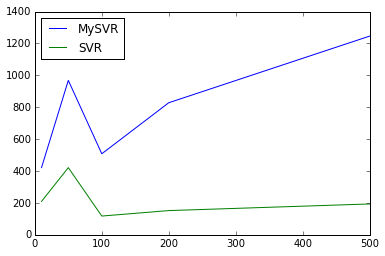

In [195]:
plt.plot(N, my_scores, label = 'MySVR')
plt.plot(N, svr_scores, label = 'SVR')
plt.legend(loc = 'best')

plt.show()

#### Problem 11
Choose any simple real-world regression problem (e.g., use the Boston data set by calling load_boston from
sklearn.datasets ). Split these data into train and test. Compare the accuracy of your implementation of
SVR and Kernel Ridge Regression (KRR) from sklearn on this data set. For choosing hyperparameters, you
can use grid search.

In [190]:
boston = load_boston()
X = sklearn.preprocessing.normalize(boston.data)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.33, random_state=42)
predictor = MySVR(kernel='polynomial', p=3, C=1000000., epsilon=0.1)
predictor.fit(X_train, y_train)
y_estimate = predictor.predict(X_test)
err = round(sklearn.metrics.mean_squared_error(y_estimate, y_test),2)
print ("SVR score is {0}".format(err))

krr = KernelRidge(kernel = 'rbf', alpha = 0.1, gamma = 10)
krr.fit(X_train, y_train)
y_estimate = krr.predict(X_test)
err = round(sklearn.metrics.mean_squared_error(y_estimate, y_test),2)
print ("KKR score is {0}".format(err))

SVR score is 18.26
KKR score is 24.9
